In [13]:
import numpy as np
from matplotlib import pyplot as plt

FC = 35 #liter / hour
MK1_density = 0.815 #kg / liter
P_cons = 110 #kWh / hour
P_consICE = (83.6 / 0.95 / 0.9 / 0.8) #122.2 kWh / hour

t_b = 10 #years, battery lifetime
t_f = 25 #years, ferry lifetime

#Energimyndigheten, 2021 values:
CO2 = 2580 #g CO2 eq. / liter
HVO = 520  #g CO2 eq. / liter
MK1_hv = 35.3 #MJ / liter, heat value
#SMED, 2020 values:
SO2 = 36.0 #g / GJ
PM = 0.27  #g / GJ

#Electricity mix:
CO2_e = 30 #g CO2 eq. / kWh

#Battery production:
CO2_battery = 240 #kg CO2 eq. / kWh

#Engine production:
CO2_engine = 37.75 #kg CO2 eq. / kW
kW_engine = 257

#Electric motor production:
CO2_motor = 19.6 #kg CO2 eq. / kW, assumed same kW as engines

#MGO production:
CO2_fuel = 12.5 #kg CO2 eq. / MJ

#If one is interested:
sfoc = 1000 * (FC * MK1_density) / P_cons #g / kWh
#print(sfoc) 

#ELVY AND ELOISE: 1 x SCANIA DI13 257 kW Tier III
#ÄLVELI AND ÄLVFRIDA: 2 x SCANIA DI09 257 kW Tier II


In [14]:
#IMO Regulation 13:
CO2_diesel = np.zeros(4)
CO2_electricity = np.zeros(4)
CO2_batteryProd = np.zeros(4)
CO2_engineProd = np.zeros(4)
CO2_electricityProd = np.zeros(4)
CO2_fuelProd = np.zeros(4)


def TierII_NOX(rpm):
    return 44*pow(rpm,-0.23) #g / kWh

def TierIII_NOX(rpm):
    return 9*pow(rpm,-0.2)

#CO2, SO2 and PM functions:

def CO2_calc(t_op, e_f, q):
    #q acts as an index. A different value is stored for each ferry
    CO2_diesel[q] = CO2 * FC * t_op * (1 - e_f)  #Diesel part
    CO2_electricity[q] = CO2_e * P_cons * t_op * e_f #Electricity part
    CO2_ret = CO2_diesel[q] + CO2_electricity[q]
    
    
    return CO2_ret

def SO2_calc(t_op, e_f):
    SO2_ret = SO2 * FC * (MK1_hv / 1000) * t_op * (1 - e_f)
    return SO2_ret
                                    
def PM_calc(t_op, e_f):
    PM_ret = PM * FC * (MK1_hv / 1000) * t_op * (1 - e_f)
    return PM_ret 
                                              
def emissionCalc(t_op, e_f, tier, rpm, q): 
    
    CO2_result = CO2_calc(t_op, e_f, q)
    SO2_result = SO2_calc(t_op, e_f)
    PM_result = PM_calc(t_op, e_f)
    
    #NOx emissions:        
    if tier == 2:
        NOX_result = TierII_NOX(rpm) * P_consICE * t_op * (1 - e_f)
    elif tier == 3:
        NOX_result = TierIII_NOX(rpm) * P_consICE * t_op * (1 - e_f)
    else:
        print("Incompatible tier")
      
    return [CO2_result, NOX_result, SO2_result, PM_result]

def summary4(f1,f2,f3,f4):
    
    res = np.array([f1, f2, f3, f4]) / 1000
    res = res.sum(axis=0)
    
    print("GHGs: " + str(f'{res[0]:.5f}'))
    print("NOx: " + str(f'{res[1]:.5f}'))
    print("SOx: " + str(f'{res[2]:.5f}'))
    print("PM: " + str(f'{res[3]:.5f}'))
    
   
    
    return res

def summary5(f1,f2,f3,f4,f5):
   
    res = np.array([f1,f2,f3,f4,f5]) / 1000
    res = res.sum(axis=0)
    
    print("GHGs: " + str(f'{res[0]:.5f}'))
    print("NOx: " + str(f'{res[1]:.5f}'))
    print("SOx: " + str(f'{res[2]:.5f}'))
    print("PM: " + str(f'{res[3]:.5f}'))
    
    return res
    
def upstreamCalc(f, kWh_init, kWh, kW, t_op, e_f, q):
    
    CO2_batteryProd[q] = (CO2_battery * (kWh_init + (kWh * (t_f / t_b)))) / (t_f * 365) * 1000 #Battery production
    CO2_engineProd[q] = ((CO2_engine * kW) / (t_f * 365)) * 1000   #Engine production
    CO2_electricityProd[q] = ((2 * kW_engine * CO2_motor) / (t_f * 365)) * 1000           #Electric motor production
    CO2_fuelProd[q] = ((t_op * (1 - e_f) * FC * MK1_hv * CO2_fuel) / (t_f * 365)) * 1000 #Fuel production
    f[0] += CO2_batteryProd[q] + CO2_engineProd[q] + CO2_electricityProd[q] + CO2_fuelProd[q]

    return f #grams

In [15]:
#BASELINE
t_op1 = 13
t_op2 = 12.5
t_op3 = 8


e_f1 = 0.6154
e_f2 = 0.5200
e_f3 = 0

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650, 0)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650, 1)
ferry3 = emissionCalc(t_op3, e_f3, 2, 1650, 2) #returns grams / day
ferry4 = [0,0,0,0]

opPartBase = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000  #kilograms / day, operational part of GHG emissions

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, t_op1, e_f1, 0) #returns grams / day
ferry2 = upstreamCalc(ferry2, 1000, 1000, kW_engine, t_op2, e_f2, 1)
ferry3 = upstreamCalc(ferry3, 0, 0, 2 * kW_engine, t_op3, e_f3, 2)
ferry4 = upstreamCalc(ferry4, 0, 0, 2 * kW_engine, 0, 0, 3)

print("Baseline Scenario emissions [kg / day]:")
BASE = summary4(ferry1,ferry2,ferry3,ferry4) #returns kilograms / day

#Separate the results so that they can be visualized individually:
base_d = CO2_diesel.sum() / 1000
base_e = CO2_electricity.sum() / 1000
base_b = CO2_batteryProd.sum() / 1000
base_misc = (CO2_engineProd.sum() + CO2_electricityProd.sum() + CO2_fuelProd.sum()) / 1000

Baseline Scenario emissions [kg / day]:
GHGs: 2014.52835
NOx: 10.57804
SOx: 0.84507
PM: 0.00634


In [16]:
#Big Battery
t_op1 = 11
t_op2 = 10.5
t_op3 = 9
t_op = 3

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1


ferry1 = emissionCalc(t_op1, e_f1, 3, 1650, 0)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650, 1)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 2)
ferry4 = emissionCalc(t_op3, e_f4, 3, 1650, 3)

opPartBB = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, 0, 0, 0)
ferry2 = upstreamCalc(ferry2, 1260, 1260, kW_engine, 0, 0, 1)
ferry3 = upstreamCalc(ferry3, 1260, 1260, kW_engine, 0, 0, 2)
ferry4 = upstreamCalc(ferry4, 1000, 1000, kW_engine, 0, 0, 3)

print("Big Battery Scenario emissions [kg / day]:")
BB = summary4(ferry1,ferry2,ferry3,ferry4)

bb_d = CO2_diesel.sum() / 1000
bb_e = CO2_electricity.sum() / 1000
bb_b = CO2_batteryProd.sum() / 1000
bb_misc = (CO2_engineProd.sum() + CO2_electricityProd.sum() + CO2_fuelProd.sum()) / 1000

Big Battery Scenario emissions [kg / day]:
GHGs: 579.04092
NOx: 0.00000
SOx: 0.00000
PM: 0.00000


In [17]:
#Optimize Battery
t_op1 = 8
t_op2 = 8.5
t_op3 = 9
t_op4 = 8

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650, 0)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650, 0)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 0)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650, 0)

opPartOBS = (ferry1[0] + ferry2[0] + ferry3[0] + ferry4[0]) / 1000

ferry1 = upstreamCalc(ferry1, 1260, 670, kW_engine, 0, 0, 0)
ferry2 = upstreamCalc(ferry2, 1000, 670, kW_engine, 0, 0, 1)
ferry3 = upstreamCalc(ferry3, 670, 670, kW_engine, 0, 0, 2)
ferry4 = upstreamCalc(ferry4, 670, 670, kW_engine, 0, 0, 3)

print("OBS Scenario emissions [kg / day]:")
OBS = summary4(ferry1,ferry2,ferry3,ferry4)

obs_d = CO2_diesel.sum() / 1000
obs_e = CO2_electricity.sum() / 1000
obs_b = CO2_batteryProd.sum() / 1000
obs_misc = (CO2_engineProd.sum() + CO2_electricityProd.sum() + CO2_fuelProd.sum()) / 1000

OBS Scenario emissions [kg / day]:
GHGs: 390.12311
NOx: 0.00000
SOx: 0.00000
PM: 0.00000


In [18]:
#Wireless Steady SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650, 0)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650, 1)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 2)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 3)

opPartWS = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 130, 130, kW_engine, 0, 0, 0)
ferry2 = upstreamCalc(ferry2, 130, 130, kW_engine, 0, 0, 1)
ferry3 = upstreamCalc(ferry3, 130, 130, kW_engine, 0, 0, 2)
ferry4 = upstreamCalc(ferry4, 130, 130, kW_engine, 0, 0, 3)

print("Wireless Steady SoC [kg / day]:")
WS = summary4(ferry1,ferry2,ferry3,ferry4)

ws_d = CO2_diesel.sum() / 1000
ws_e = CO2_electricity.sum() / 1000
ws_b = CO2_batteryProd.sum() / 1000
ws_misc = (CO2_engineProd.sum() + CO2_electricityProd.sum() + CO2_fuelProd.sum()) / 1000

Wireless Steady SoC [kg / day]:
GHGs: 229.69395
NOx: 0.00000
SOx: 0.00000
PM: 0.00000


In [19]:
#Wireless Falling SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650, 0)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650, 1)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 2)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650, 3)

opPartWF = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 539, 539, kW_engine, 0, 0, 0)
ferry2 = upstreamCalc(ferry2, 539, 539, kW_engine, 0, 0, 1)
ferry3 = upstreamCalc(ferry3, 539, 539, kW_engine, 0, 0, 2)
ferry4 = upstreamCalc(ferry4, 539, 539, kW_engine, 0, 0, 3)

print("Wireless Falling SoC [kg / day]:")
WF = summary4(ferry1,ferry2,ferry3,ferry4)

wf_d = CO2_diesel.sum() / 1000
wf_e = CO2_electricity.sum() / 1000
wf_b = CO2_batteryProd.sum() / 1000
wf_misc = (CO2_engineProd.sum() + CO2_electricityProd.sum() + CO2_fuelProd.sum()) / 1000

Wireless Falling SoC [kg / day]:
GHGs: 394.42997
NOx: 0.00000
SOx: 0.00000
PM: 0.00000


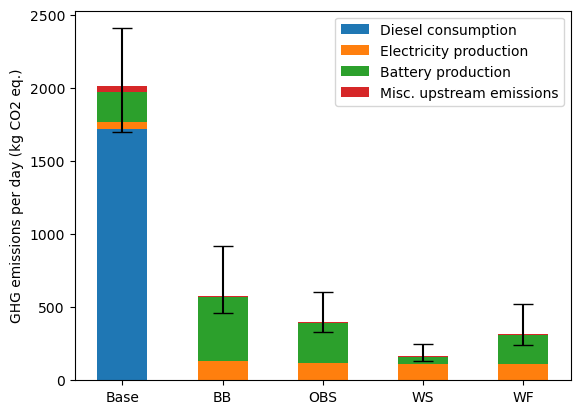

In [20]:
#SUMMARY

scenarios = (
    "Base",
    "BB",
    "OBS",
    "WS",
    "WF",
)
emissions = {
    "Diesel consumption": np.array([base_d, bb_d, obs_d, ws_d, wf_d]),
    "Electricity production": np.array([base_e, bb_e, obs_e, ws_e, wf_e]),
    "Battery production": np.array([base_b, bb_b, obs_b, ws_b, wf_b]),
    "Misc. upstream emissions": np.array([base_misc, bb_misc, obs_misc, ws_misc, wf_misc]),

}
totEm = [BASE[0], BB[0], OBS[0], WS[0], WF[0]]
y_errormin = [totEm[0] - 1696, totEm[1] - 463, totEm[2] - 317, totEm[3] - 192, totEm[4] - 318] 
y_errormax = [2408 - totEm[0], 918 - totEm[1], 597 - totEm[2], 312 - totEm[3], 600 - totEm[4]]
yerror = [y_errormin, y_errormax]
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(5)
i=0
for boolean, emissions in emissions.items():
    
    if i == 3:
        p = ax.bar(scenarios, emissions, width, label=boolean, bottom=bottom, yerr=yerror, capsize=7)
        bottom += emissions
    else:
        p = ax.bar(scenarios, emissions, width, label=boolean, bottom=bottom)
        bottom += emissions
        i += 1
    
ax.set_ylabel('Total cost (SEK / day)')
ax.set_ylabel('GHG emissions per day (kg CO2 eq.)')
ax.legend(loc="best")

plt.show()

0.006338048283000001


<BarContainer object of 4 artists>

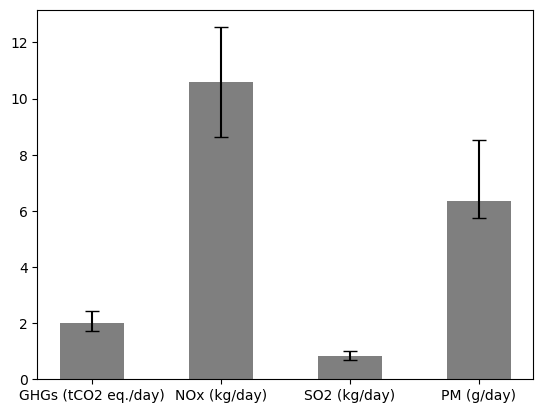

In [21]:
#BASELINE EMISSIONS

fig, ax = plt.subplots()
#ax = fig.add_axes([0,0,1,1])
cases = ['GHGs (tCO2 eq./day)', 'NOx (kg/day)', 'SO2 (kg/day)', 'PM (g/day)']
GHGs = [BASE[0] / 1000, BASE[1], BASE[2], BASE[3] * 1000]

y_errormin = [(BASE[0] - 1707.987) / 1000, BASE[1] - 8.633, BASE[2] - 0.679, (BASE[3] - 0.00574) * 1000]
y_errormax = [(2417.637 - BASE[0]) / 1000, 12.538 - BASE[1], 1.011 - BASE[2], (0.00854 - BASE[3]) * 1000]
yerror = [y_errormin, y_errormax]


print(BASE[3])
#bar_labels = ['red', 'blue', 'blue', 'orange', 'green', 'green']
#bar_colors = ['tab:red', (0.1, 1, 0.1, 1), (0, 1, 0, 1), 'tab:blue', (1, 0.9, 0, 1), (1, 0.9, 0, 1)]

ax.bar(cases, GHGs, width=0.5, color='tab:grey', yerr=yerror, capsize=5)




Text(0.5, 0, 'Scenario')

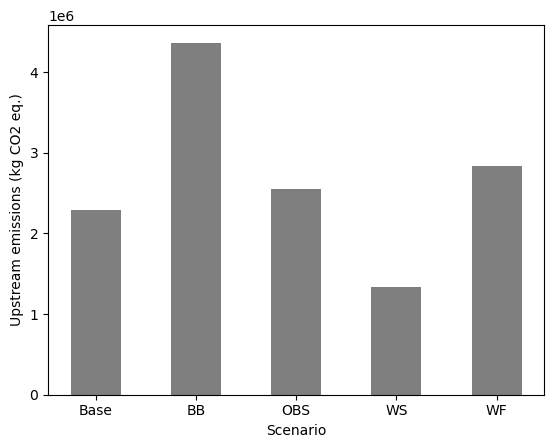

In [22]:
#EXTRA: Upstream emissions bar chart

BASE_u = (BASE[0] - opPartBase) * (t_f * 365) #Multiply upstream emissions per day with amount of days during lifetime 
BB_u = (BB[0] - opPartBB) * (t_f * 365)
OBS_u = (OBS[0] - opPartOBS) * (t_f * 365)
WS_u = (WS[0] - opPartWS) * (t_f * 365)
WF_u = (WF[0] - opPartWF) * (t_f * 365)
fig, ax = plt.subplots()
#ax = fig.add_axes([0,0,1,1])
cases = ['Base', 'BB', 'OBS', 'WS', 'WF']
GHGs = [BASE_u, BB_u, OBS_u, WS_u, WF_u]

#bar_labels = ['red', 'blue', 'blue', 'orange', 'green', 'green']
#bar_colors = ['tab:red', (0.1, 1, 0.1, 1), (0, 1, 0, 1), 'tab:blue', (1, 0.9, 0, 1), (1, 0.9, 0, 1)]
ax.bar(cases, GHGs, color = 'tab:grey', width=0.5)
ax.set_ylabel('Upstream emissions (kg CO2 eq.)')
ax.set_xlabel('Scenario')
